In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from TensorMesolve import *
from math import *
from cmath import exp
import qutip as q
from PartialTrace import ptrace
import Plotexpect as plot 

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
ws = 2*pi*0.450 #secular freq
Delta = 2*pi*1e2 #detuning from 3/2
W1 = 2*pi*2.24385 #Rabi frequency for 1st laser
W2 = 2*pi*2.24385  #Rabi frequency for 2nd laser
Rabi = W1**2/(4*Delta) #Effective Rabi frequency 
eta = 0.0384313 #parameter Lambe-Dike
mu =  4*eta*Rabi
d = mu+ws #detuning between lasers
tau = 2*pi/mu
N = 5 #number of Fock states

In [4]:
tau

516.80568469979

In [5]:
a = q.destroy(N)
zero = q.basis(3, 0)
one = q.basis(3, 1) 
exc = q.basis(3, 2)

#ions operators
up = one.proj()
down = zero.proj()
ex = exc.proj()
gr = up+down

dx = -1j*eta*(a+a.dag())
C11 = dx.expm()
C21 = C11.dag()
C12 = -1j*C11
C22 = 1j*C21

In [6]:
#Hamiltonian time independent
#first ion
crossup = one*exc.dag()
H10 = W1/2 * (q.tensor(C11, crossup, q.qeye(3))+q.tensor(C12,  q.qeye(3), crossup))
H1 = H10+ H10.dag()

H2 = W2/2 * (q.tensor(C21, crossup,  q.qeye(3))+ q.tensor(C22,  q.qeye(3),crossup))
H3 = H2.dag()

Hstark =  2*Rabi*q.tensor(q.qeye(N), up,  q.qeye(3)) +2*Rabi*q.tensor(q.qeye(N), q.qeye(3), up) 
Henergy = Delta*q.tensor(q.qeye(N), ex, q.qeye(3))+ Delta*q.tensor(q.qeye(N), q.qeye(3), ex)
H0 = ws * q.tensor(q.num(N), q.qeye(3), q.qeye(3)) +Hstark+ H1+Henergy #full time nondependent Hummy  



In [7]:
H0 = tf.constant(H0.full(), dtype=tf.complex64)
H2 = tf.constant(H2.full(), dtype=tf.complex64)
H3 = tf.constant(H3.full(), dtype=tf.complex64)

In [8]:
#print(psi0)
#hadamard gate H
n_th = 0. # avg number of thermal bath excitation

hadamard = 1 / sqrt(2.0) * q.Qobj([[1, 1, 0], [1, -1, 0], [0, 0, sqrt(2.0)]])
#pi/2 pulse
S = 1 / sqrt(2.0) * q.Qobj([[1, 1, 0], [-1, 1, 0], [0, 0, sqrt(2.0)]])

Bellstate = hadamard*one
# initial state
osc_init = q.Qobj(q.thermal_dm(N, n_th).diag())
psi0 = q.tensor(osc_init, Bellstate, Bellstate)    # start with a Bell state
rho0 = q.tensor(q.thermal_dm(N, n_th), Bellstate*Bellstate.dag(), Bellstate*Bellstate.dag()) 
psi0 = tf.constant(psi0.full(), dtype=tf.complex64)
rho0 = tf.constant(rho0.full(), dtype=tf.complex64)


In [9]:
def calc_timedepH(drive):
    Ht = drive[0,:,tf.newaxis,tf.newaxis]*H2[tf.newaxis] +\
         drive[1,:,tf.newaxis,tf.newaxis]*H3[tf.newaxis]
    return Ht +  H0[tf.newaxis, :, :] 

model = VirtQ(calc_timedepH)

In [10]:
def calc_Phi3D(t):
    Drive = [[],[]]
    Drive[0].append(exp(1j*d*t))                
    Drive[1].append(exp(-1j*d*t))
    
    return np.asarray(Drive)

In [11]:
phi_id = 1 / np.sqrt(2.0) * (q.tensor(q.basis(3, 0), q.basis(3, 0)) - 1j*q.tensor(q.basis(3, 1), q.basis(3, 1)))
dd = np.matrix(q.tensor(zero, zero).full())
uu = np.matrix(q.tensor(one, one).full())
ud = np.matrix(q.tensor(one, zero).full())
du = np.matrix(q.tensor(zero, one).full())
S2 = np.matrix(q.tensor(S, S).full())
target = np.matrix(phi_id.full())

In [12]:
def p00(state):
    return dd.getH()@S2@ptrace(np.asarray(state), [N, 9], 0)@S2.getH()@dd
    
def p11(state):
    return uu.getH()@S2@ptrace(np.asarray(state), [N, 9], 0)@S2.getH()@uu

def p10(state):
    return  ud.getH()@S2@ptrace(np.asarray(state), [N, 9], 0)@S2.getH()@ud

def p01(state):
    return  du.getH()@S2@ptrace(np.asarray(state), [N, 9], 0)@S2.getH()@du


def P(state):
    return [p00(state), p01(state), p10(state), p11(state)]

def inFid(state):
    return 1-target.getH()@S2@ptrace(np.asarray(state), [N, 9], 0)@S2.getH()@target

def res(state):
    return np.abs(np.asarray([*P(state), inFid(state)]).reshape(5))


# Вычисления

In [15]:
model.set_initstate(psi0)
Nsteps = int(1e6) #number of steps for calculation
savestep = 100
timelist = np.linspace(0, 2*tau, Nsteps) #array of time
model.set_timelist(timelist)
model.set_Lindblad_operators([])

In [16]:
output = model.solveSE(calc_Phi3D, progress_bar=True, solver = 'RK4', e_ops = res, savestep = savestep)
output = np.array(output)

100%|████████████████████████████████████████████████████████████████████████| 999999/999999 [2:53:54<00:00, 95.84it/s]


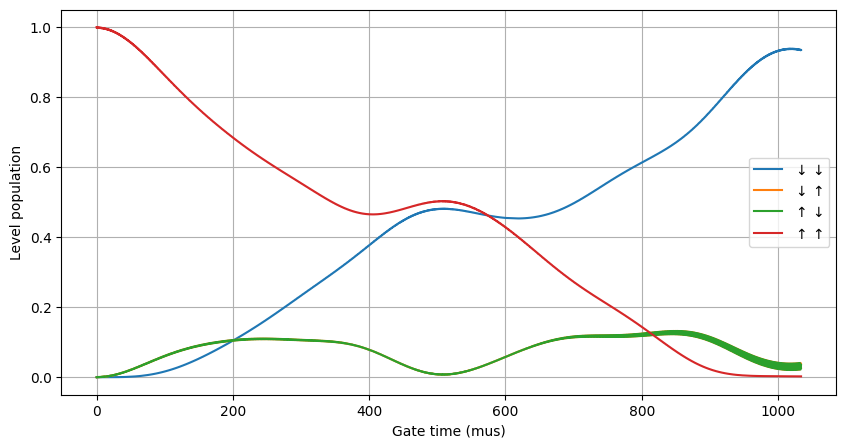

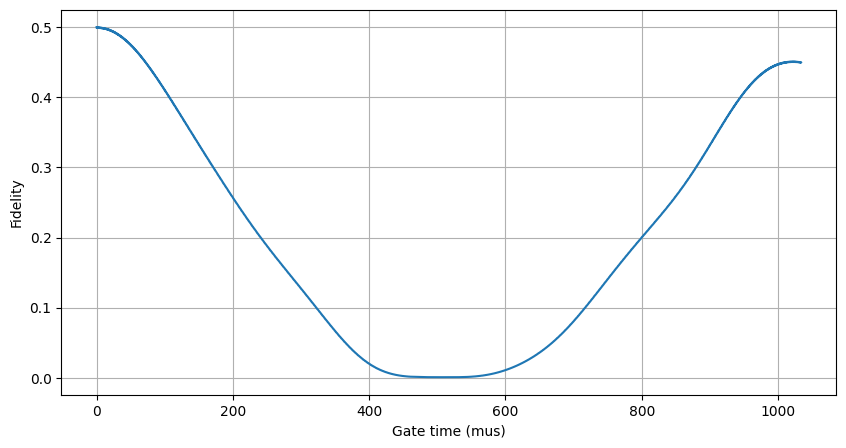

In [18]:
tplot = np.linspace(0, 2*tau, Nsteps//savestep) #array of time
plot.plotP(tplot, output)
plot.Fid_plot(tplot, output)

In [ ]:
plot(tplot, output[:,]

In [24]:
np.sum(output[:,0:4], axis = 1)

array([1.        , 0.99932741, 0.99916539, ..., 0.99960706, 0.99960688,
       0.99960832])

In [26]:
np.max(output[:, 4])

0.9992388598620892